In [1]:
import numpy as np
import os
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
import seaborn as sns
import codebase
from codebase import volume_pipeline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
# Selct location
res_name = 'Powell'
grdc_id = 4152050

In [4]:
# Filepaths
grdc_dir = '/global/scratch/users/ann_scheliga/aux_dam_datasets/GRDC_CRB/'
met_dir = '/global/scratch/users/ann_scheliga/era5_test_data/'

## Load data

In [5]:
# Load reservoir dataset
res_shp = codebase.load_data.load_GRanD()
res_name_dict = {'Powell':'glen canyon',
                 'Mead': 'hoover',
                 'Mohave': 'davis bor',
                 'Havasu': 'parker'}

In [15]:
# Load subset CYGNSS reservoir data
subset_gpd = codebase.area_subsets.check_for_multiple_dams(res_name_dict[res_name], res_shp)
subset_bbox = subset_gpd.geometry.buffer(0).bounds
subset_bbox
# dem_DA , fw_DA = volume_pipeline.create_aligned_DEM_CYGNSS_subsets(res_name_dict[res_name],res_shp,epsg_code=54017)

,minx,miny,maxx,maxy
596,-111.570835,36.937778,-111.221875,37.105153


In [7]:
# Load GRDC data
watershed_gpd, grdc_Q = codebase.load_data.load_GRDC_station_data_by_ID(grdc_id,filepath=grdc_dir)

In [8]:
# Load ERA5 data, subset to GRDC watershed
tempK_files = codebase.utils.grab_matching_names_from_filepath(met_dir,r'daily_tempK')
precip_files = codebase.utils.grab_matching_names_from_filepath(met_dir,r'daily_tot_precip')
type_precip_files = codebase.utils.grab_matching_names_from_filepath(met_dir,r'daily_precip_type')

concat_dict = {'dim':'valid_time'}

tempK_xr = codebase.area_subsets.era5_shape_subset_and_concat(ordered_filenames=tempK_files,
                                                                 filepath=met_dir,
                                                                 concat_dict=concat_dict,
                                                                subset_gpd=watershed_gpd)
precip_xr = codebase.area_subsets.era5_shape_subset_and_concat(ordered_filenames=precip_files,
                                                                 filepath=met_dir,
                                                                 concat_dict=concat_dict,
                                                                subset_gpd=watershed_gpd)
type_precip_xr = codebase.area_subsets.era5_shape_subset_and_concat(ordered_filenames=type_precip_files,
                                                                 filepath=met_dir,
                                                                 concat_dict=concat_dict,
                                                                subset_gpd=watershed_gpd)

Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!


## Calculate inputs

In [9]:
tempK_xr.dims

('valid_time', 'latitude', 'longitude')

Projected to equal area


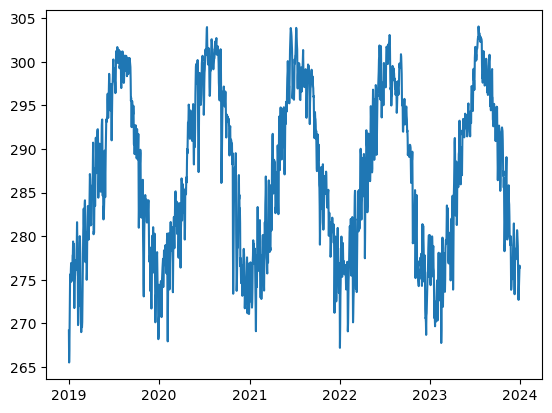

In [10]:
# Areal-average of met data
tempK_1dim = codebase.area_calcs.CYGNSS_001_areal_average(tempK_xr,x_dim = 'longitude', y_dim = 'latitude',with_index = 'valid_time')
plt.plot(tempK_1dim)

In [12]:
# Calculate CYGNSS area data
area = codebase.area_calcs.CYGNSS_001_area_calculation(fw_DA).to_frame() / (10**6)
area.head()

,0
2018-08-01,316.816250
2018-09-01,298.685200
2018-10-01,310.136390
2018-11-01,344.489959
2018-12-01,343.535693


In [3]:
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector

2024-12-05 13:05:17.467918: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 13:05:18.439034: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 13:05:18.852031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733432719.289204 1833317 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733432719.447638 1833317 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 13:05:20.649935: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Fit model

In [10]:
area_train, area_test, elev_train, elev_test = train_test_split(area, elev, test_size=0.2, random_state=23)

In [11]:
print(f'X train shape: {area_train.shape}; y train shape: {elev_train.shape}')
print(f'X test shape: {area_test.shape}; y test shape: {elev_test.shape}')

X train shape: (45, 1); y train shape: (45, 1)
X test shape: (12, 1); y test shape: (12, 1)


In [12]:
model = LinearRegression()
model.fit(area_train,elev_train)

LinearRegression()

## Evaluate model (train/test)

In [13]:
print(f'Training R^2: {model.score(area_train, elev_train)}')
print(f'Test R^2: {model.score(area_test, elev_test)}')

Training R^2: 0.6416045084867384
Test R^2: 0.37122030132552875


In [14]:
elev_train_pred = model.predict(area_train)
elev_test_pred = model.predict(area_test)
elev_pred = model.predict(area)

In [15]:
print(f'Train RMSE: {mean_squared_error(elev_train, elev_train_pred, squared=False)}')
print(f'Test RMSE: {mean_squared_error(elev_test, elev_test_pred, squared=False)}')

Train RMSE: 3.3096551043975353
Test RMSE: 3.6153480167418586


In [16]:
model.coef_ , model.intercept_

(array([[0.08586632]]), array([1128.65335458]))

## Evaluate model to USBR

In [17]:
elev_pred_df = pd.DataFrame(index = area.index, data = elev_pred)
elev_pred_df.head()

,0
2018-08-01,1155.857199
2018-09-01,1154.300352
2018-10-01,1155.283624
2018-11-01,1158.233438
2018-12-01,1158.151499


<Axes: xlabel='Datetime (UTC)'>

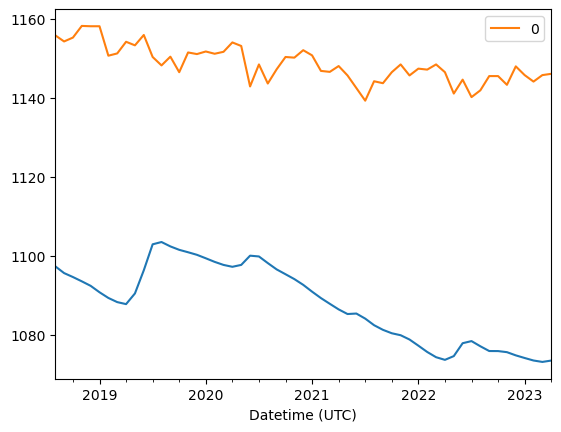

In [18]:
elev_ref_match , elev_pred_match = codebase.time_series_calcs.intersecting_timeframes(elev_ref,elev_pred_df,buffer=0)
ax = elev_ref_match.plot()
elev_pred_match.plot(ax=ax)

In [19]:
print(f'RMSE to USBR: {mean_squared_error(elev_ref_match , elev_pred_match, squared=False)}')

RMSE to USBR: 61.209457471017


## Use model to calculate volume

In [20]:
deltV_ref_m3 = codebase.utils.convert_from_af_to_m3(res_ref['Lake/Reservoir Change In Storage [af]'])

In [21]:
deltV_calc_km2_m = volume_pipeline.calculate_trapezoidal_volume(area=area, elev=elev_pred) # units: km2 * m

In [23]:
deltV_calc_m3 = pd.DataFrame(index=area.index[1:],data=deltV_calc_km2_m) * (10**6) 

In [26]:
print(deltV_calc_m3.cumsum().tail())
deltV_ref_m3.cumsum().tail()

                       0
2022-12-01 -2.131823e+09
2023-01-01 -2.601561e+09
2023-02-01 -2.912764e+09
2023-03-01 -2.601561e+09
2023-04-01 -2.535567e+09


Datetime (UTC)
2023-09-01   -2.151791e+08
2023-10-01   -2.178989e+08
2023-11-01   -2.215708e+08
2023-12-01   -2.290496e+08
2024-01-01   -2.396685e+08
Name: Lake/Reservoir Change In Storage [af], dtype: float64

In [28]:
deltV_ref_match , deltV_calc_match = codebase.time_series_calcs.intersecting_timeframes(deltV_ref_m3 , deltV_calc_m3,buffer=0)

<Axes: xlabel='Datetime (UTC)'>

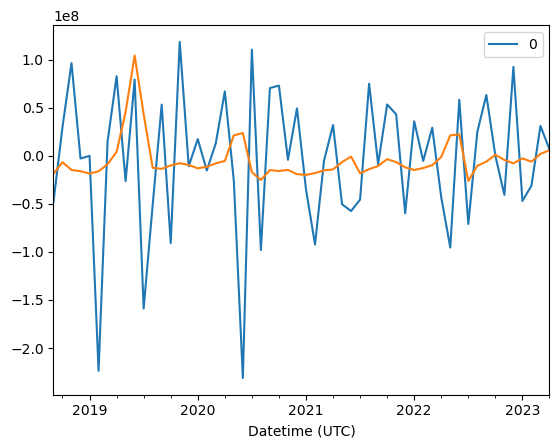

In [31]:
ax = (deltV_calc_match/10).plot()
deltV_ref_match.plot(ax=ax)